# PCB AC analysis

This example shows how to use PyAEDT to create a design in
Q3D Extractor and run a simulation starting from an EDB project.

Keywords: **Q3D**, **PCB**.

## Perform imports and define constants

Perform required imports.

In [1]:
import os
import tempfile
import time

In [2]:
import ansys.aedt.core
import pyedb

Define constants.

In [3]:
AEDT_VERSION = "2024.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

## Create temporary directory

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [4]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

## Set up project files and path

Download needed project file and set up temporary project directory.

In [5]:
project_dir = os.path.join(temp_folder.name, "edb")
aedb_project = ansys.aedt.core.downloads.download_file(
    source="edb/ANSYS-HSD_V1.aedb", destination=project_dir
)

project_name = os.path.join(temp_folder.name, "HSD")
output_edb = os.path.join(project_dir, project_name + ".aedb")
output_q3d = os.path.join(project_dir, project_name + "_q3d.aedt")

## Open EDB and create cutout

Open the EDB project and create a cutout on the selected nets
before exporting to Q3D.

In [6]:
edb = pyedb.Edb(aedb_project, edbversion=AEDT_VERSION)
cutout_points = edb.cutout(
    ["CLOCK_I2C_SCL", "CLOCK_I2C_SDA"],
    ["GND"],
    output_aedb_path=output_edb,
    use_pyaedt_extent_computing=True,
)

PyAEDT INFO: Logger is initialized in EDB.


PyAEDT INFO: legacy v0.31.0


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: Database ANSYS-HSD_V1.aedb Opened in 2024.2


PyAEDT INFO: Cell main Opened


PyAEDT INFO: Builder was initialized.


PyAEDT INFO: EDB initialized.


PyAEDT INFO: EDB file save time: 0.00ms


PyAEDT INFO: Cutout Multithread started.


PyAEDT INFO: Net clean up Elapsed time: 0m 2sec


PyAEDT INFO: Extent Creation Elapsed time: 0m 0sec


PyAEDT INFO: 1956 Padstack Instances deleted. Elapsed time: 0m 1sec


PyAEDT INFO: 420 Primitives deleted. Elapsed time: 0m 3sec


PyAEDT INFO: 994 components deleted


PyAEDT INFO: EDB file save time: 15.64ms


PyAEDT INFO: Cutout completed. Elapsed time: 0m 6sec


## Identify locations of pins

Identify $(x,y)$ pin locations on the components to define where to assign sources
and sinks for Q3D.

In [7]:
pin_u13_scl = [
    i for i in edb.components["U13"].pins.values() if i.net_name == "CLOCK_I2C_SCL"
]
pin_u1_scl = [
    i for i in edb.components["U1"].pins.values() if i.net_name == "CLOCK_I2C_SCL"
]
pin_u13_sda = [
    i for i in edb.components["U13"].pins.values() if i.net_name == "CLOCK_I2C_SDA"
]
pin_u1_sda = [
    i for i in edb.components["U1"].pins.values() if i.net_name == "CLOCK_I2C_SDA"
]

## Append Z elevation positions

> **Note:** The factor 1000 converts from meters to millimeters.

In [8]:
location_u13_scl = [i * 1000 for i in pin_u13_scl[0].position]
location_u13_scl.append(edb.components["U13"].upper_elevation * 1000)

location_u1_scl = [i * 1000 for i in pin_u1_scl[0].position]
location_u1_scl.append(edb.components["U1"].upper_elevation * 1000)

location_u13_sda = [i * 1000 for i in pin_u13_sda[0].position]
location_u13_sda.append(edb.components["U13"].upper_elevation * 1000)

location_u1_sda = [i * 1000 for i in pin_u1_sda[0].position]
location_u1_sda.append(edb.components["U1"].upper_elevation * 1000)

## Save and close EDB

Save and close EDB. Then, open the EDB project in HFSS 3D Layout to generate the 3D model.

In [9]:
edb.save_edb()
edb.close_edb()

h3d = ansys.aedt.core.Hfss3dLayout(
    output_edb, version=AEDT_VERSION, non_graphical=NG_MODE, new_desktop=True
)

PyAEDT INFO: EDB file save time: 0.00ms


PyAEDT INFO: EDB file release time: 0.00ms


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_31799c38-10e6-472b-9856-beab6b7e179c.log is enabled.


PyAEDT INFO: Log on AEDT is enabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 59190


PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64


PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 7192.


PyAEDT INFO: EDB folder C:\Users\ansys\AppData\Local\Temp\tmputrfw0hs.ansys\HSD.aedb has been imported to project HSD


PyAEDT INFO: Active Design set to 0;main


PyAEDT INFO: Aedt Objects correctly read


## Set up the Q3D Project

Use HFSS 3D Layout to export the model to Q3D Extractor. The named parameter
``keep_net_name=True`` ensures that net names are retained when the model is exported from HFSS 3D Layout.

In [10]:
setup = h3d.create_setup()
setup.export_to_q3d(output_q3d, keep_net_name=True)
h3d.close_project()
time.sleep(3)

PyAEDT INFO: Project: HSD, Design: main, [info]  Translation Info: Export complete (00:00:04). (04:27:17 AM  Oct 31, 2024)


PyAEDT INFO: Project: HSD, Design: main, [info]  File written to C:/Users/ansys/AppData/Local/Temp/tmputrfw0hs.ansys/HSD_q3d.aedt. (04:27:17 AM  Oct 31, 2024)


PyAEDT INFO: Loading Modeler.


PyAEDT INFO: Modeler loaded.


PyAEDT INFO: EDB loaded.


PyAEDT INFO: Layers loaded.


PyAEDT INFO: Primitives loaded.


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Logger is initialized in EDB.


PyAEDT INFO: legacy v0.31.0


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: Database HSD.aedb Opened in 2024.2


PyAEDT INFO: Cell main Opened


PyAEDT INFO: Builder was initialized.


PyAEDT INFO: EDB initialized.


PyAEDT INFO: Processing net GND...


PyAEDT INFO: Processing net CLOCK_I2C_SDA...


PyAEDT INFO: Processing net CLOCK_I2C_SCL...


PyAEDT INFO: Net processing completed.


PyAEDT INFO: Processing vias...


PyAEDT INFO: Vias processing completed.


PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmputrfw0hs.ansys\HSD_q3d.aedt.


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Returning found Desktop session with PID 7192!


PyAEDT INFO: Project HSD_q3d has been opened.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmputrfw0hs.ansys\HSD_q3d.aedt correctly loaded. Elapsed time: 0m 3sec


PyAEDT INFO: Active Design set to Q3DDesign1


PyAEDT INFO: Aedt Objects correctly read


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Renaming primitives for net GND...


PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: Union of 2 objects has been executed.


PyAEDT INFO: Renaming primitives for net CLOCK_I2C_SDA...


PyAEDT INFO: Union of 5 objects has been executed.


PyAEDT INFO: Renaming primitives for net CLOCK_I2C_SCL...


PyAEDT INFO: Union of 5 objects has been executed.


PyAEDT INFO: No new nets identified


PyAEDT INFO: Closing the AEDT Project HSD_q3d


PyAEDT INFO: Project HSD_q3d closed correctly


PyAEDT INFO: EDB file release time: 15.63ms


PyAEDT INFO: Closing the AEDT Project HSD


PyAEDT INFO: Project HSD closed correctly


Open the newly created Q3D project and display the layout.

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmputrfw0hs.ansys\HSD_q3d.aedt.


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Returning found Desktop session with PID 7192!


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmputrfw0hs.ansys\HSD_q3d.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: Project HSD_q3d has been opened.


PyAEDT INFO: Active Design set to Q3DDesign1


PyAEDT INFO: Aedt Objects correctly read


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


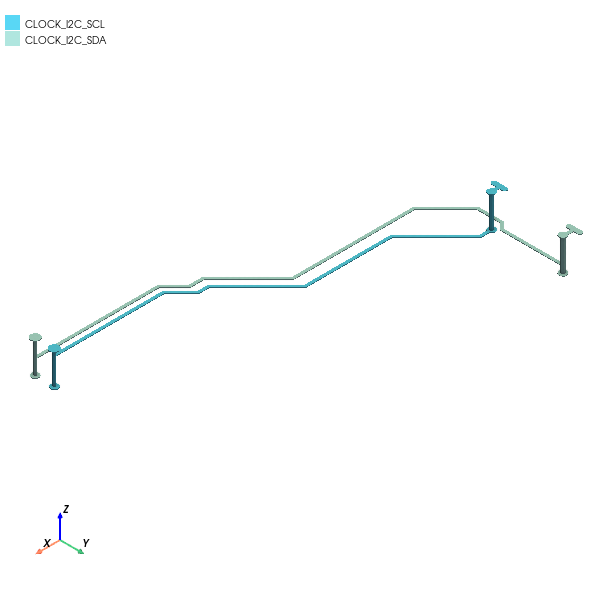

In [11]:
q3d = ansys.aedt.core.Q3d(output_q3d, version=AEDT_VERSION)
q3d.plot(
    show=False,
    assignment=["CLOCK_I2C_SCL", "CLOCK_I2C_SDA"],
    output_file=os.path.join(temp_folder.name, "Q3D.jpg"),
    plot_air_objects=False,
)

Use the previously calculated positions to identify faces and
assign sources and sinks on nets.

In [12]:
f1 = q3d.modeler.get_faceid_from_position(location_u13_scl, assignment="CLOCK_I2C_SCL")
q3d.source(f1, net_name="CLOCK_I2C_SCL")
f1 = q3d.modeler.get_faceid_from_position(location_u13_sda, assignment="CLOCK_I2C_SDA")
q3d.source(f1, net_name="CLOCK_I2C_SDA")
f1 = q3d.modeler.get_faceid_from_position(location_u1_scl, assignment="CLOCK_I2C_SCL")
q3d.sink(f1, net_name="CLOCK_I2C_SCL")
f1 = q3d.modeler.get_faceid_from_position(location_u1_sda, assignment="CLOCK_I2C_SDA")
q3d.sink(f1, net_name="CLOCK_I2C_SDA")

PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


Define the solution setup and the frequency sweep ranging from DC to 2GHz.

In [13]:
setup = q3d.create_setup()
setup.dc_enabled = True
setup.capacitance_enabled = False
sweep = setup.add_sweep()
sweep.add_subrange(
    "LinearStep", 0, end=2, count=0.05, unit="GHz", save_single_fields=False, clear=True
)
setup.analyze(cores=NUM_CORES)

PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Q3D Extractor correctly changed.


PyAEDT INFO: Solving design setup MySetupAuto


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Q3D Extractor correctly changed.


PyAEDT INFO: Design setup MySetupAuto solved correctly in 0.0h 4.0m 23.0s


## Solve

Compute AC inductance and resistance.

In [14]:
traces_acl = q3d.post.available_report_quantities(quantities_category="ACL Matrix")
solution = q3d.post.get_solution_data(traces_acl)

PyAEDT INFO: Solution Data Correctly Loaded.


## Postprocess

Plot AC inductance and resistance.

PyAEDT INFO: Solution Data Correctly Loaded.


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ansys\aedt\core\visualization\plot\matplotlib.py:407: RuntimeWarning: invalid value encountered in divide
  theta = np.arccos(z / r) * 180 / math.pi  # to degrees


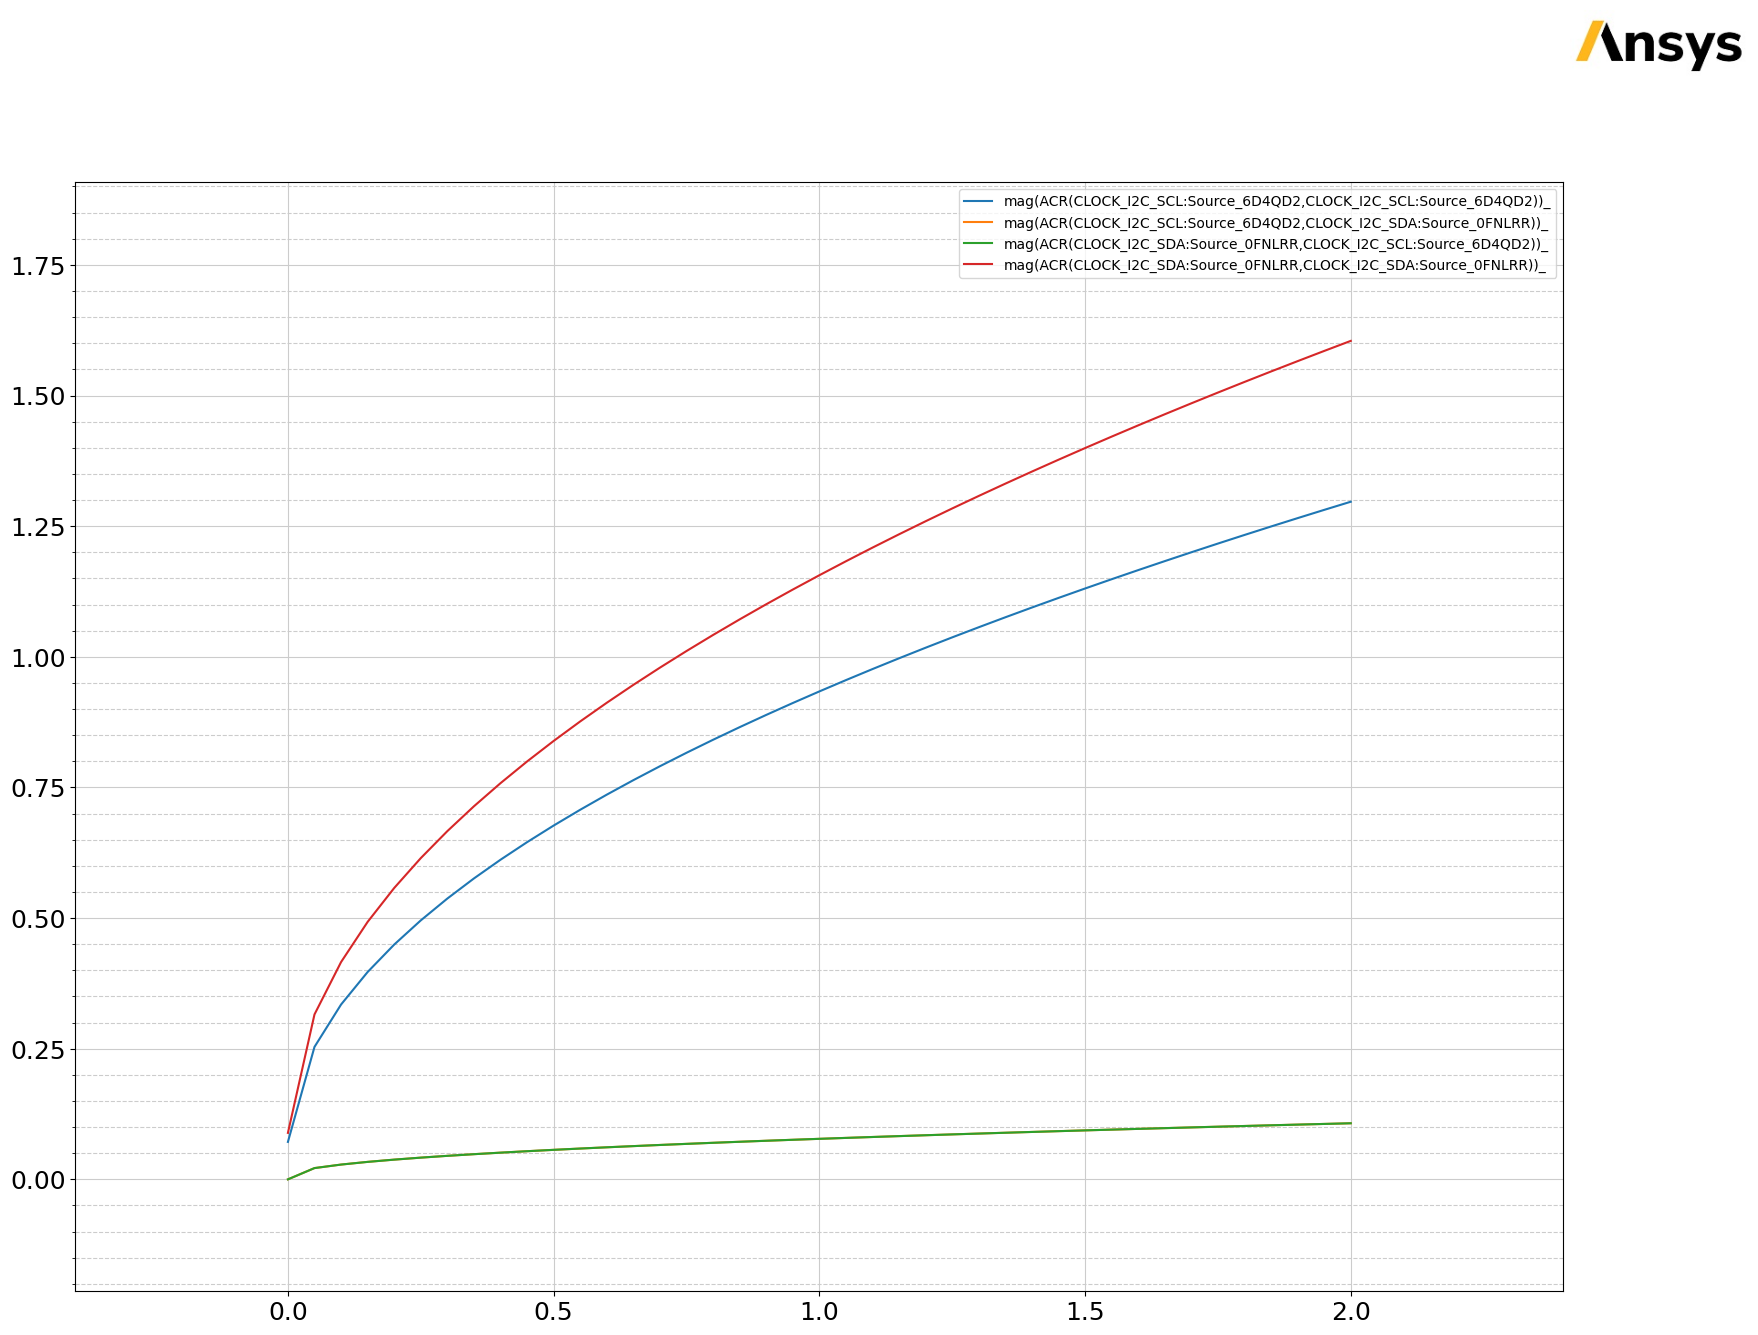

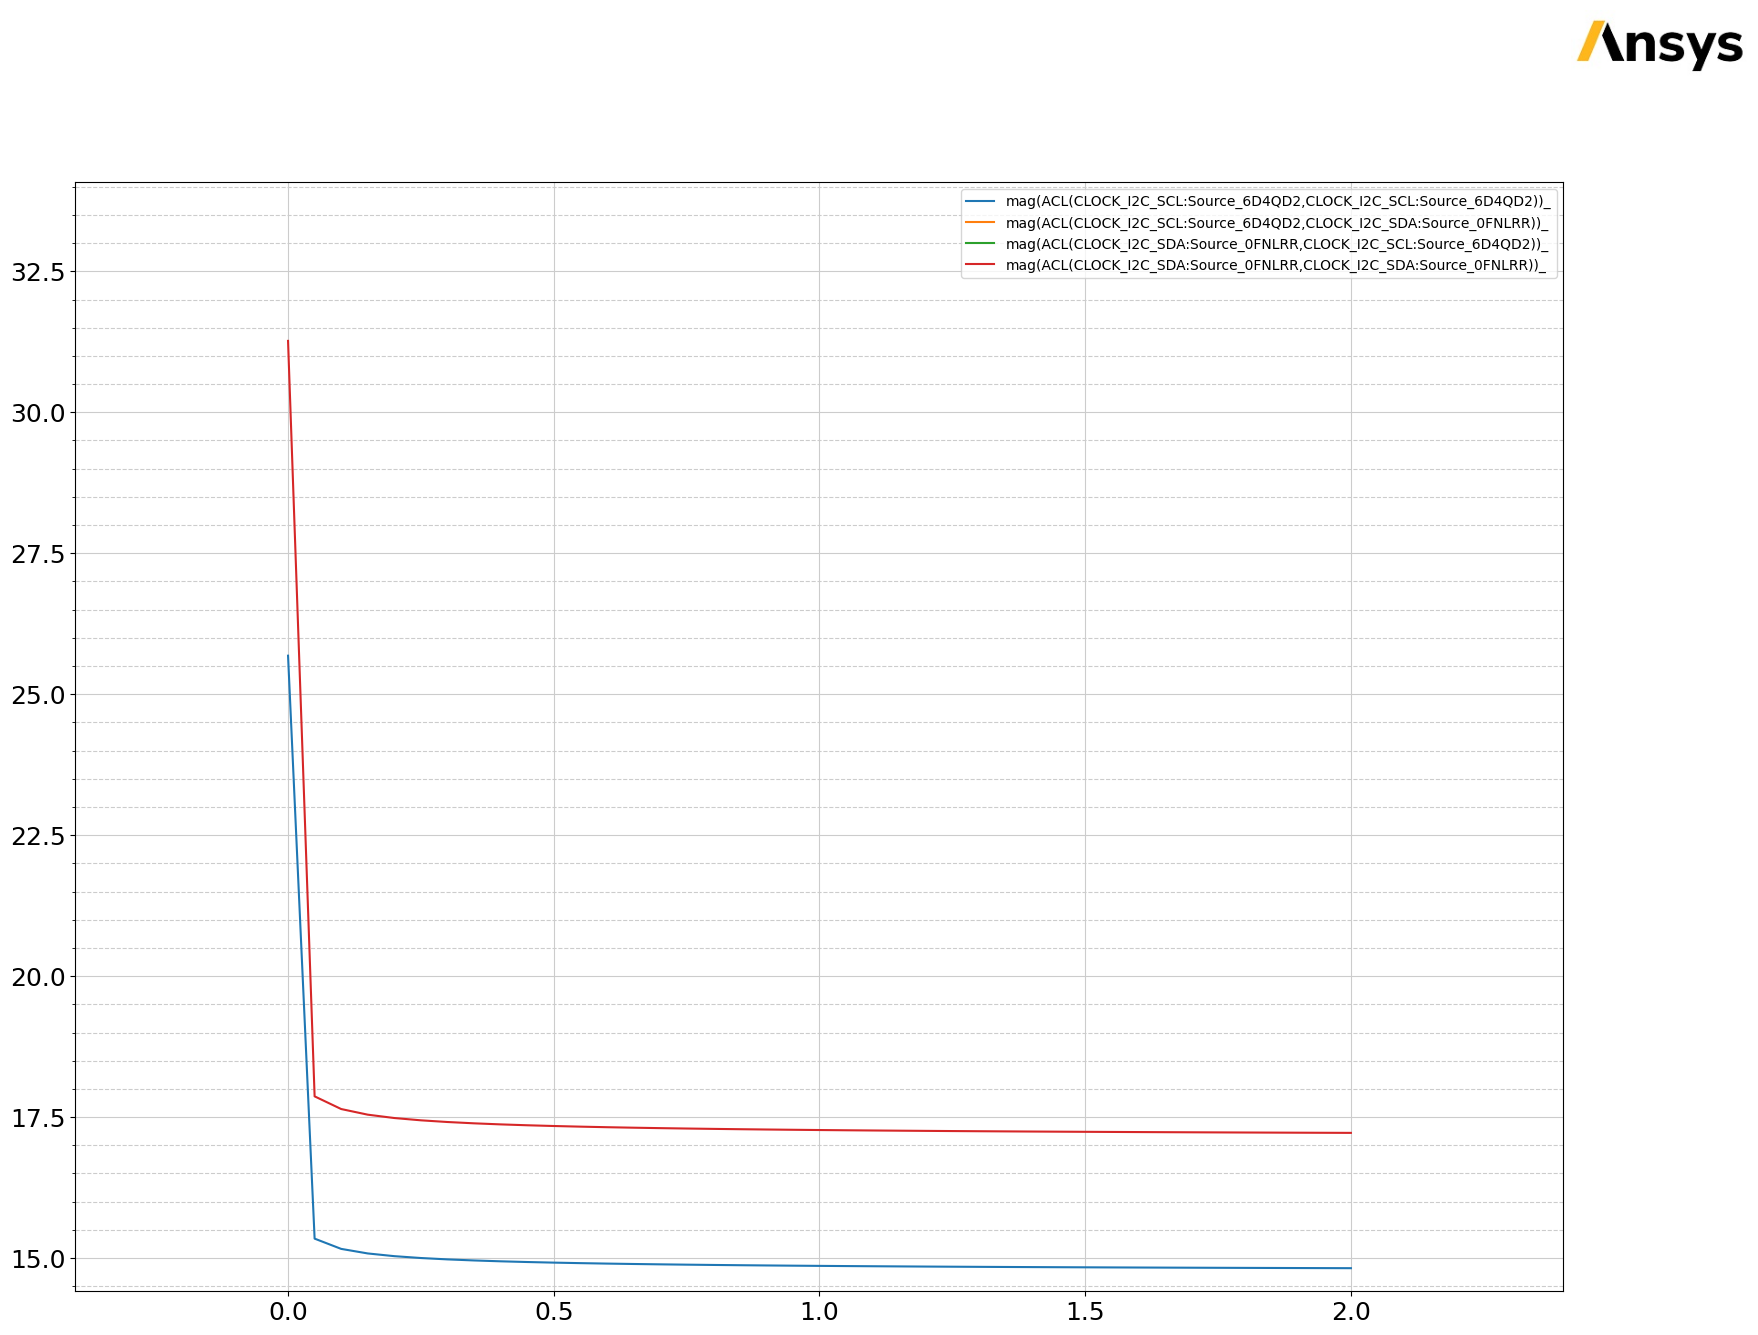

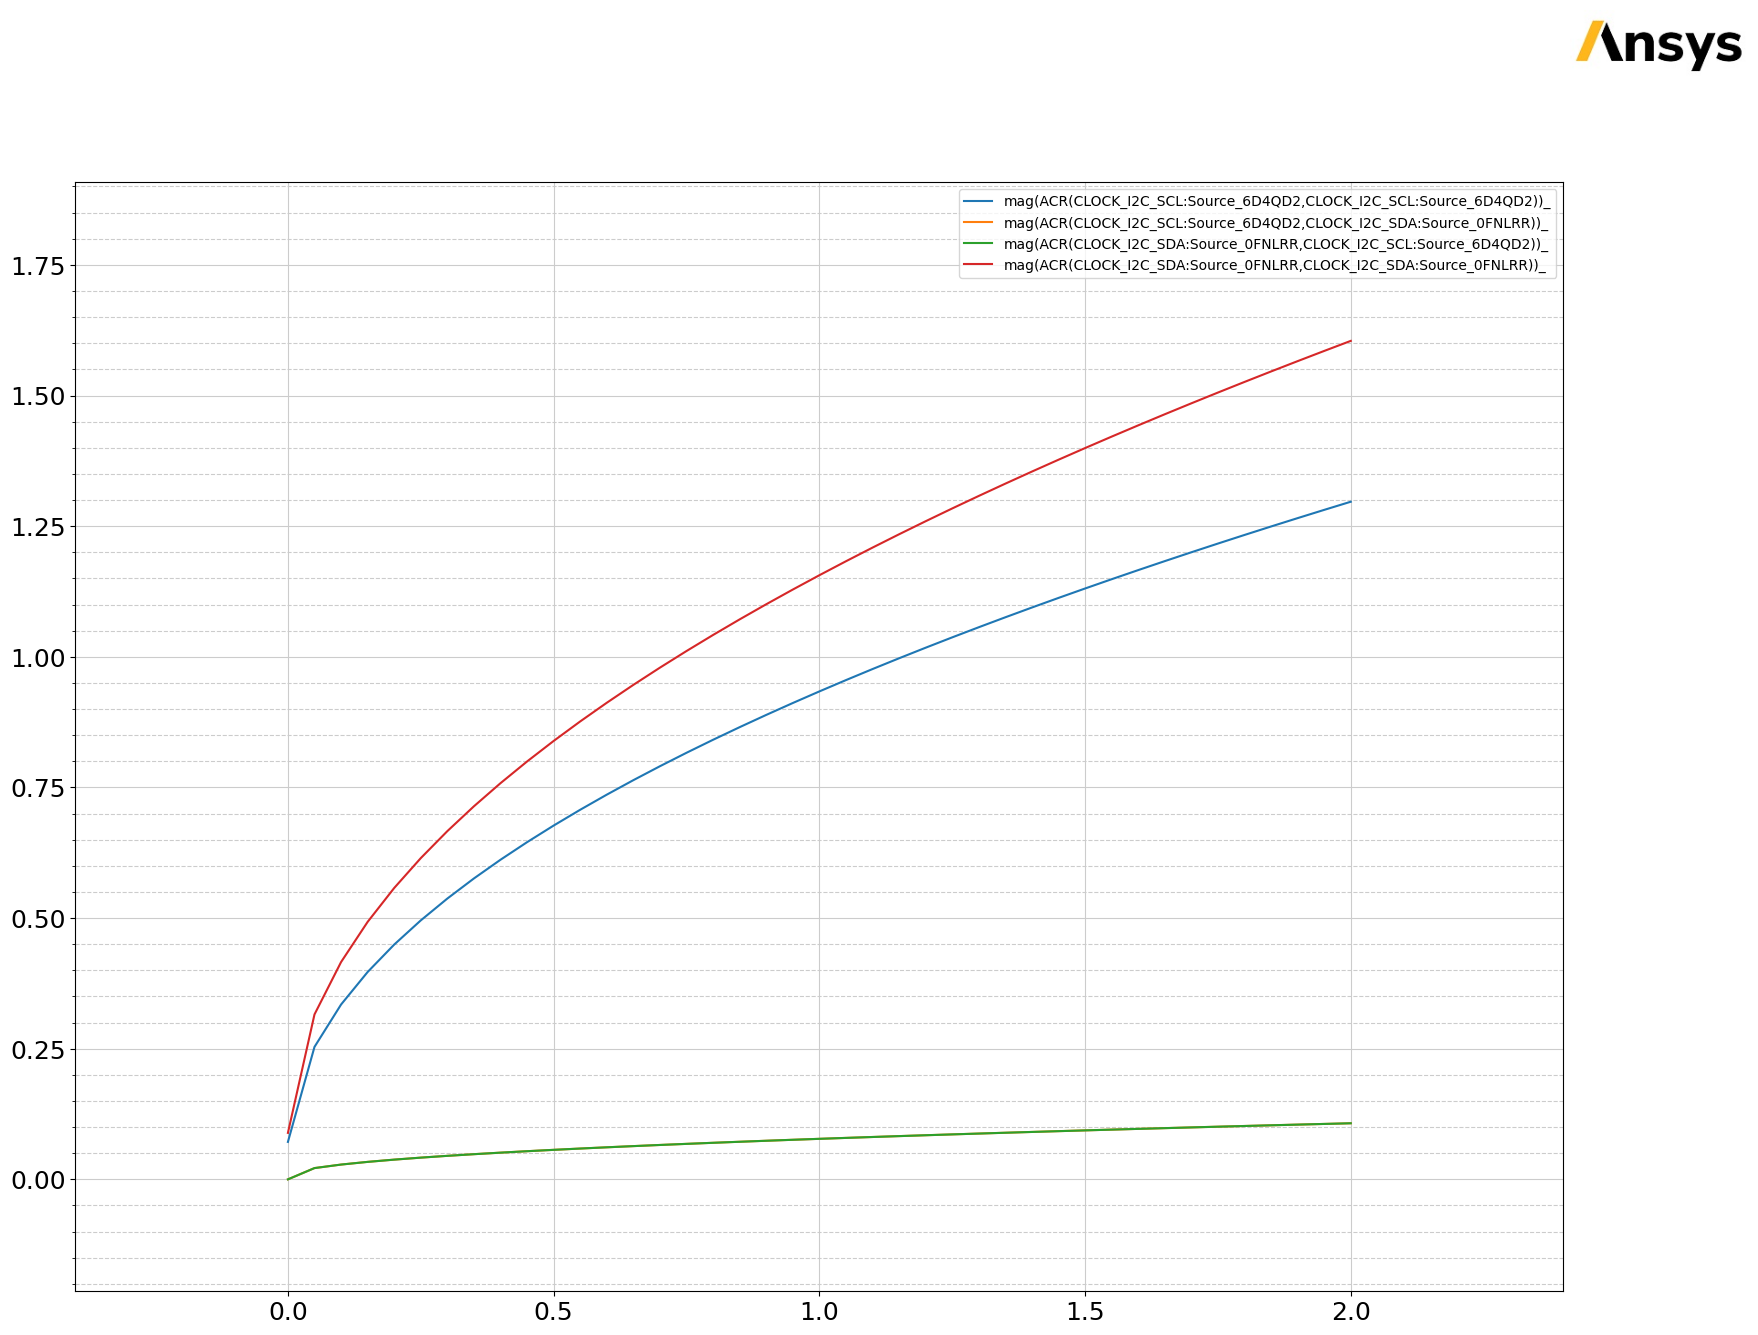

In [15]:
solution.plot()
traces_acr = q3d.post.available_report_quantities(quantities_category="ACR Matrix")
solution2 = q3d.post.get_solution_data(traces_acr)
solution2.plot()

## Release AEDT

In [16]:
q3d.save_project()
q3d.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project HSD_q3d Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell
removes all temporary files, including the project folder.

In [17]:
temp_folder.cleanup()